In [2]:
import numpy as np
import os
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import nibabel as nib
from nibabel.testing import data_path
import scipy
from scipy.stats import mode
from scipy.ndimage import rotate
from scipy import optimize
from scipy.optimize import minimize
import cv2
from PIL import Image

In [3]:
# only call this once, it might take a while
def get_middle_slice(img):
    img_data = img.get_fdata()
    slice_2 = img_data[:, :, len(img_data[0][0])//2]
    slice_2 = rotate(slice_2, 90)
    return slice_2

# get paths to images
path = os.getcwd()
training_path = path + '/Data/Training'
validation_path = path + '/Data/Validation'
testing_path = path + '/Data/Testing'
middle_coronal_path = path + '/MiddleSliceImages'

# load images
img1 = nib.load(training_path + '/IBSR_01/images/analyze/IBSR_01_ana.img')
img2 = nib.load(training_path + '/IBSR_02/images/analyze/IBSR_02_ana.img')
img3 = nib.load(training_path + '/IBSR_03/images/analyze/IBSR_03_ana.img')
img4 = nib.load(training_path + '/IBSR_04/images/analyze/IBSR_04_ana.img')
img5 = nib.load(training_path + '/IBSR_05/images/analyze/IBSR_05_ana.img')
img6 = nib.load(training_path + '/IBSR_06/images/analyze/IBSR_06_ana.img')
img7 = nib.load(validation_path + '/IBSR_07/images/analyze/IBSR_07_ana.img')
img8 = nib.load(testing_path + '/IBSR_08/images/analyze/IBSR_08_ana.img')
img9 = nib.load(testing_path + '/IBSR_09/images/analyze/IBSR_09_ana.img')
img10 = nib.load(testing_path + '/IBSR_10/images/analyze/IBSR_10_ana.img')
img11 = nib.load(testing_path + '/IBSR_11/images/analyze/IBSR_11_ana.img')
img12 = nib.load(testing_path + '/IBSR_12/images/analyze/IBSR_12_ana.img')
img13 = nib.load(testing_path + '/IBSR_13/images/analyze/IBSR_13_ana.img')
img14 = nib.load(testing_path + '/IBSR_14/images/analyze/IBSR_14_ana.img')
img15 = nib.load(validation_path + '/IBSR_15/images/analyze/IBSR_15_ana.img')
img16 = nib.load(testing_path + '/IBSR_16/images/analyze/IBSR_16_ana.img')
img17 = nib.load(testing_path + '/IBSR_17/images/analyze/IBSR_17_ana.img')
img_array = np.array([img1, img2, img3, img4, img5, img6, img7, img8, img9, img10, 
                      img11, img12, img13, img14, img15, img16, img17])

# load segmentation image
img_seg1 = nib.load(training_path + '/IBSR_01/segmentation/analyze/IBSR_01_seg_ana.img')
img_seg2 = nib.load(training_path + '/IBSR_02/segmentation/analyze/IBSR_02_seg_ana.img')
img_seg3 = nib.load(training_path + '/IBSR_03/segmentation/analyze/IBSR_03_seg_ana.img')
img_seg4 = nib.load(training_path + '/IBSR_04/segmentation/analyze/IBSR_04_seg_ana.img')
img_seg5 = nib.load(training_path + '/IBSR_05/segmentation/analyze/IBSR_05_seg_ana.img')
img_seg6 = nib.load(training_path + '/IBSR_06/segmentation/analyze/IBSR_06_seg_ana.img')
img_seg7 = nib.load(validation_path + '/IBSR_07/segmentation/analyze/IBSR_07_seg_ana.img')
img_seg15 = nib.load(validation_path + '/IBSR_15/segmentation/analyze/IBSR_15_seg_ana.img')
img_seg_array = np.array([img_seg1, img_seg2, img_seg3, img_seg4, img_seg5, img_seg6, img_seg7, img_seg15])

training_imgs, testing_imgs, validation_imgs, segments = [], [], [], []
for i in range(0, 6): 
    training_imgs.append(get_middle_slice(img_array[i]))
for i in [6, 14]: 
    validation_imgs.append(get_middle_slice(img_array[i]))
for i in [7, 8, 9, 10, 11, 12, 13, 15, 16]: 
    testing_imgs.append(get_middle_slice(img_array[i]))
for i in range(len(img_seg_array)):
    segments.append(get_middle_slice(img_seg_array[i]))

### Part 1. Write a function that computes a 4-parameter geometric registration (global scale, rotation, and translations along two axes) between two mid-coronal MRI slices from two different subjects (a fixed image and a moving image). 

In [4]:
"""
Inputs: - moving_img, type numpy array
        - parameters, (4 transformation parameters)
            - scale
            - rotation angle in degrees
            - translation (col, row)
        - grid_size, (col, row)
Returns: sum of squared differences between the geometrically transformed moving image and the fixed image
"""
def transform(moving_img, parameters, grid_size):
    scale, angle, t_c, t_r = parameters
    h, w = moving_img.shape[0], moving_img.shape[1]
    o_h, o_w = grid_size[0], grid_size[1]
    
    # rotate and scale image
    rotation_mat = cv2.getRotationMatrix2D((w // 2, h // 2), angle, scale)
    rotated_img = cv2.warpAffine(moving_img, rotation_mat, (w, h))
    
    # translate image
    translation_mat = np.array([[1, 0, float(t_c)], [0, 1, float(t_r)]])
    translated_img = cv2.warpAffine(rotated_img, translation_mat, (o_w, o_h)) 
    
    return translated_img

In [5]:
"""
Inputs: - moving_img, type numpy array
        - parameters, (4 transformation parameters)
            - scale
            - rotation angle in degrees
            - translation (col, row)
        - fixed_img, type numpy array
Returns: sum of squared differences between the geometrically transformed moving image and the fixed image
"""
def loss(parameters, moving_img, fixed_img): 
    transformed_img = transform(moving_img, parameters, fixed_img.shape)
    
    temp1 = np.array(fixed_img).flatten()
    temp2 = np.array(transformed_img).flatten()
    
    loss = np.sum(np.power(temp1-temp2, 2))
    return loss

In [6]:
"""
Inputs: - moving_img, type numpy array
        - fixed_img, type numpy array
Returns: - optimized_params (4 transformation parameters)
         - optimized_img
"""
def optimize(fixed_img, moving_img):
    optimized_params = scipy.optimize.fmin(loss, (1, 0, 0, 0), args=(fixed_img, moving_img))
    optimized_img = transform(moving_img, optimized_params, fixed_img.shape)
    return optimized_params, optimized_img

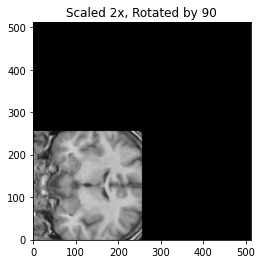

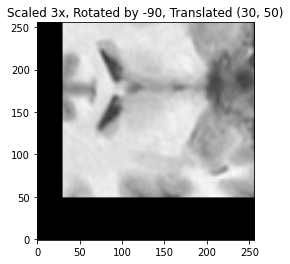

In [7]:
a = transform(training_imgs[0], (2, 90, 0, 0), (512,512))
b = transform(training_imgs[1], (3, -90, 30, 50), (256,256))

plt.figure(1)
plt.title('Scaled 2x, Rotated by 90')
plt.imshow(a.squeeze(), cmap = 'gray', origin="lower")
plt.figure(2)
plt.title('Scaled 3x, Rotated by -90, Translated (30, 50)')
plt.imshow(b.squeeze(), cmap = 'gray', origin="lower")

In [8]:
def geometricRegistration(fixed_img, moving_img):
    height, width, c = fixed_img.shape
    
    #initialize an array of zeros of size MxN
    normalizedImg = np.zeros((height,width))
    #compute the normalized fixed image
    normalized_fixed_img = cv2.normalize(fixed_img,  normalizedImg, 0, 255, cv2.NORM_MINMAX)
    
    #initialize an array of zeros of size MxN
    normalizedImg = np.zeros((height,width))
    #compute the normalized moving image
    normalized_moving_img = cv2.normalize(moving_img,  normalizedImg, 0, 255, cv2.NORM_MINMAX)
    
    #compute optimal parameters, and the geometric transformed image with these optimal parameters
    opt_params, transf_img = optimize(normalized_fixed_img,normalized_moving_img)
    
    #return the geometrically transformed image with optimal paramenters
    return opt_params, transf_img    

### Part 2. Use your registration tool to resample each training image (moving) onto each validation image (fixed) (i.e., you need to run 12 registration instances). Visualize some slices of these results. You need to show that your registration works - i.e., plot results for before the registration and after the registration.

Optimization terminated successfully.
         Current function value: 52342583.094619
         Iterations: 48
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: 51368600.679249
         Iterations: 56
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: 60368806.906864
         Iterations: 68
         Function evaluations: 148
Optimization terminated successfully.
         Current function value: 37464538.239977
         Iterations: 61
         Function evaluations: 142
Optimization terminated successfully.
         Current function value: 80237295.017487
         Iterations: 46
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: 28979691.534924
         Iterations: 63
         Function evaluations: 156
Optimization terminated successfully.
         Current function value: 83727773.098755
         Iterations: 55
         Func

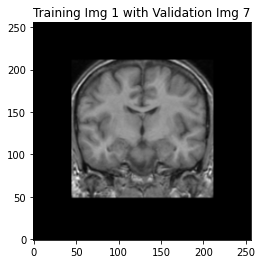

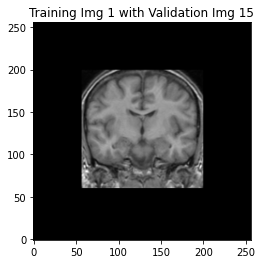

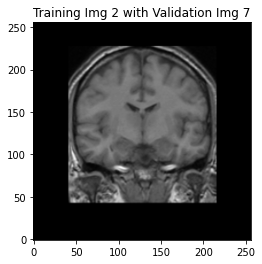

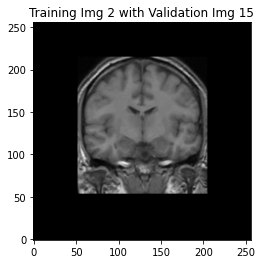

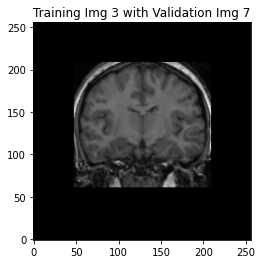

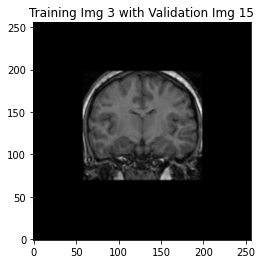

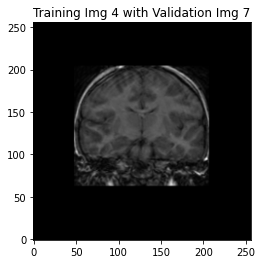

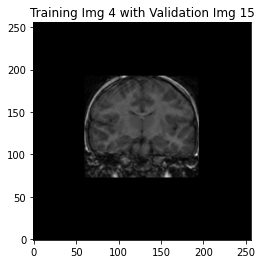

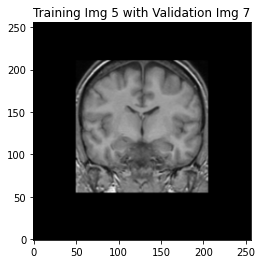

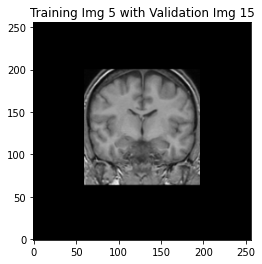

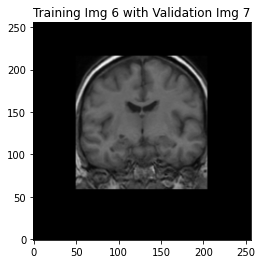

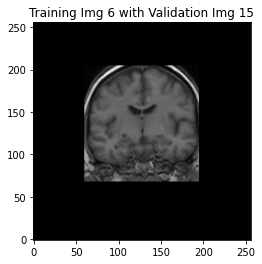

In [9]:
optimized_params, registered_imgs = [], []

training = [1, 2, 3, 4, 5, 6]
validation = [7, 15]
t_i, v_i = 0, 0
fig_count = 1
for moving_img in training_imgs: 
    for fixed_img in validation_imgs:
        optimized_param, registered_img = geometricRegistration(fixed_img, moving_img)
        plt.figure(fig_count)
        plt.title('Training Img ' + str(training[t_i]) + ' with Validation Img ' + str(validation[v_i]))
        plt.imshow(registered_img.squeeze(), cmap = 'gray', origin = "lower")
        optimized_params.append(optimized_param)
        registered_imgs.append(registered_img)
        v_i += 1
        fig_count += 1
    v_i = 0
    t_i += 1

### Part 3. Apply the registration results (optimal transformations) to resample the manual segmentations of each training subject onto the validation subject grids (use nearest neighbor interpolation)

In [10]:
# rewriting some functions to use nearest neighbor interpolation
def transform_nn(moving_img, parameters, grid_size):
    scale, angle, t_c, t_r = parameters
    h, w = moving_img.shape[0], moving_img.shape[1]
    o_h, o_w = grid_size[0], grid_size[1]
    
    # rotate and scale image
    rotation_mat = cv2.getRotationMatrix2D((w // 2, h // 2), angle, scale)
    rotated_img = cv2.warpAffine(moving_img, rotation_mat, (w, h), flags=cv2.INTER_NEAREST)
    
    # translate image
    translation_mat = np.array([[1, 0, float(t_c)], [0, 1, float(t_r)]])
    translated_img = cv2.warpAffine(rotated_img, translation_mat, (o_w, o_h), flags=cv2.INTER_NEAREST) 
    
    return translated_img

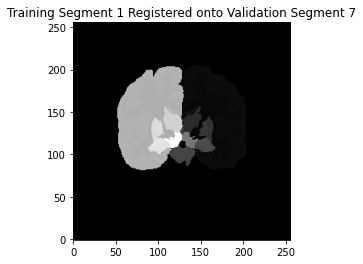

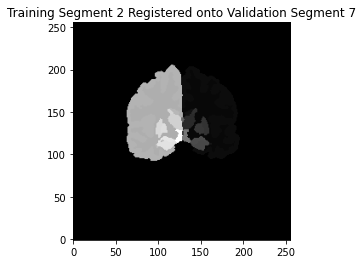

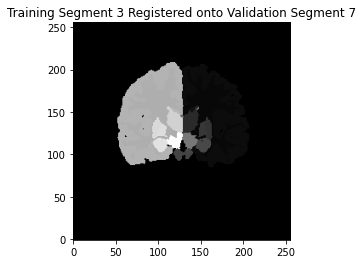

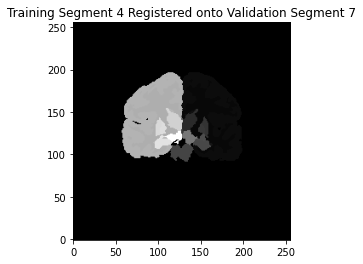

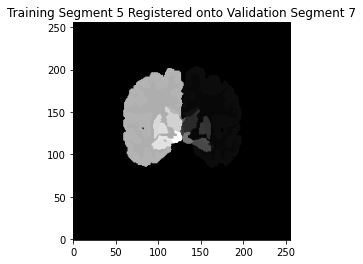

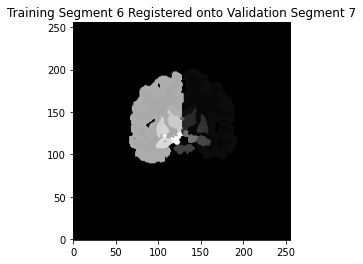

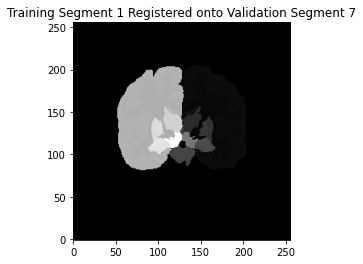

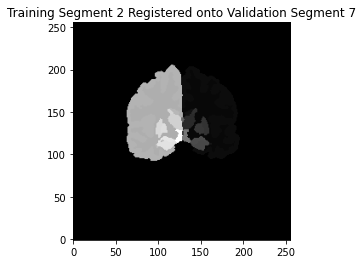

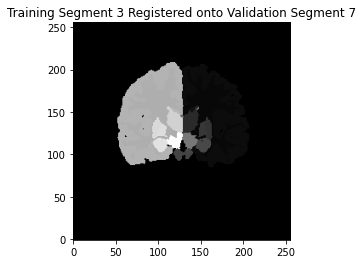

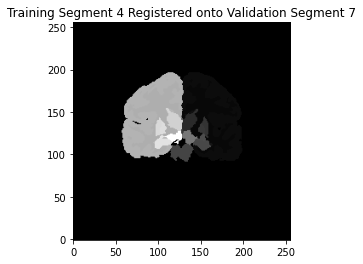

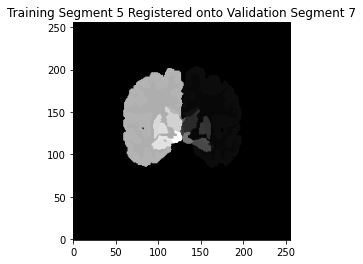

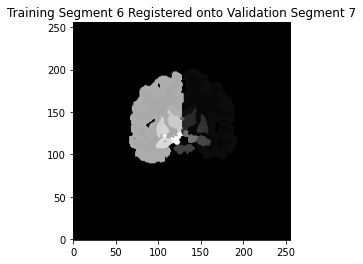

In [11]:
# training segments with validation segment 7
training_seg_1 = [transform_nn(segments[i], optimized_params[i], segments[6].shape) for i in range(6)]
# training segments with validation segment 15
training_seg_2 = [transform_nn(segments[i], optimized_params[i], segments[7].shape) for i in range(6)]

for i in range(len(training_seg_1)):
    plt.imshow(training_seg_1[i].squeeze(), cmap = 'gray', origin = 'lower')
    plt.title('Training Segment ' + str(i + 1) + ' Registered onto Validation Segment 7')
    plt.show()

for i in range(len(training_seg_2)):
    plt.imshow(training_seg_1[i].squeeze(), cmap = 'gray', origin = 'lower')
    plt.title('Training Segment ' + str(i + 1) + ' Registered onto Validation Segment 7')
    plt.show()

### Part 4. For every pixel on validation subject grid, compute the most frequent training label – this is called majority voting based label fusion. You can implement any tie-break strategy you want. This is a crude segmentation of the validation subjects.

In [12]:
reg_segs7 = np.zeros((6, 256, 256)) 
reg_segs15 = np.zeros((6, 256, 256))
for i in range (6):
    reg_segs7[i,:,:] = training_seg_1[i]
    reg_segs15[i,:,:] = training_seg_2[i]

In [13]:
def MFTL(imgs):
    modes, count = mode(imgs) # Default is axis=0, don't care about count output
    modes = modes.reshape((256, 256))
    
    return modes, count

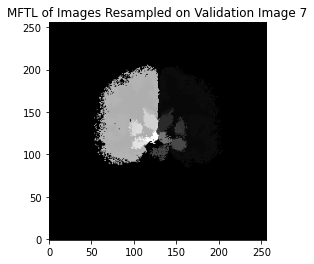

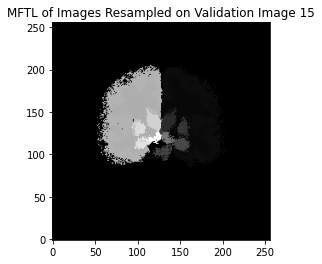

In [14]:
plt.figure(1)
modes7, count7 = MFTL(reg_segs7) 
plt.imshow(modes7, cmap = 'gray', origin = 'lower')
plt.title('MFTL of Images Resampled on Validation Image 7')
plt.savefig('MFTL_M2_7.jpg')
plt.figure(2)
modes15, count15 = MFTL(reg_segs15) 
plt.imshow(modes15, cmap = 'gray', origin = 'lower')
plt.title('MFTL of Images Resampled on Validation Image 15')
plt.savefig('MFTL_M2_15.jpg')

### Part 5. Write a function that computes the Jaccard overlap index for a given region of interest (ROI) between an input manual segmentation and an automatic segmentation. The Jaccard index is defined as the ratio between the area of the intersection and the area of the union, where the intersection and union are defined with respect to the manual segmentation and an automatic segmentation.

In [35]:
def JaccardOverlap(manual, automatic, ROI):
    manual = np.round(manual)
    manual = np.array(manual).astype(int)
    automatic = np.round(automatic)
    automatic = np.array(automatic).astype(int)

    manual_seg = np.zeros(manual.shape)
    auto_seg = np.zeros(automatic.shape)
    
    manual_seg[manual == ROI] = 1
    auto_seg[automatic == ROI] = 1
    
    manual_count = np.sum(manual_seg)
    auto_count = np.sum(auto_seg)
    
    intersect_count = np.sum(np.logical_and(manual_seg.flatten(), auto_seg.flatten()))
    union_count = np.sum(np.logical_or(manual_seg.flatten(), auto_seg.flatten()))
    return intersect_count / union_count

### Part 6. Compute the Jaccard index for your automatic validation subject segmentations. Compile these in a table and print. Only consider following regions of interest (both left and right): Cerebral-White-Matter and Cerebral-Cortex.

In [36]:
ROIs = [2, 3, 41, 42]
labels = ['Left Cerebral White-Matter, Label Fusion 7', 'Left Cerebral White-Matter, Label Fusion 15', 
          'Left Cerebral Cortex, Label Fusion 7', 'Left Cerebral Cortex, Label Fusion 15',
          'Right Cerebral White-Matter, Label Fusion 7', 'Right Cerebral White-Matter, Label Fusion 15',
          'Right Cerebral Cortex, Label Fusion 7', 'Right Cerebral Cortex, Label Fusion 15']

JOI7, JOI15 = [], []

for ROI in ROIs:
    JOI7.append(JaccardOverlap(modes7, segments[6], ROI))
    JOI7.append(JaccardOverlap(modes15, segments[6], ROI))
    JOI15.append(JaccardOverlap(modes7, segments[7], ROI))
    JOI15.append(JaccardOverlap(modes15, segments[7], ROI))

In [37]:
import pandas as pd
data = [JOI7, JOI15]
pd.DataFrame(data, columns=[*labels], index = ['Validation Segment 7', 'Validation Segment 15'])

,"Left Cerebral White-Matter, Label Fusion 7","Left Cerebral White-Matter, Label Fusion 15","Left Cerebral Cortex, Label Fusion 7","Left Cerebral Cortex, Label Fusion 15","Right Cerebral White-Matter, Label Fusion 7","Right Cerebral White-Matter, Label Fusion 15","Right Cerebral Cortex, Label Fusion 7","Right Cerebral Cortex, Label Fusion 15"
Validation Segment 7,0.432371,0.432371,0.319899,0.319899,0.445791,0.445791,0.301621,0.301621
Validation Segment 15,0.448448,0.448448,0.347524,0.347524,0.482153,0.482153,0.360150,0.360150
